# **Computer Vision Project Stage 4**

---

```
Aparajitha Sriram - 801169526
Chandan Mannem - 801165621
Monesa Thoguluva Janardhanan - 801167556
Sai Krishna Uddagiri - 801167439
```



### **A little bit about crowd counting:**

Crowd counting is the technique to count or give an estimate for the number of people in a large gathering from a picture or video like a surveillance feed.

It is useful for analyzing and estimating the number of people who attend a session or a public event. This will help to understand what kind of sessions attract larger crowds and which do not.

Crowd counting is also useful in crowd management in large public gatherings or protests and to help in coming up with efficient evacuation routes in case of emergencies.

<img src=https://www.epfl.ch/labs/cvlab/wp-content/uploads/2019/09/crowd_density_cover.jpg width=700px>

**What value will this technique provide?**

Knowing the estimate of the number of people present in an area is of vital importance in the field of advertisements as it helps to get a count of an average number of eyeballs on each ad, like in a football match with tons of ads from sponsors. Another use case is in shops which will help them estimate their flow of customers and help in product placement.

It also plays a major role in disaster management and maintaining public safety like preventing overcrowding, stampedes and planning evacuation routes in case of emergencies.
Some of the main challenges with crowd counting are occlusion (blockage or obstruction of view), clutter, irregular object distribution and varying illumination.

### **A brief about the research work we referred to**
Our project uses the research paper [1], as the main reference for our model. This research done by Li Yuhong, Xiaofan Zhang and Deming Chen proposes a network for Congested Scene Recognition called CSRNet to provide a data-driven and deep learning method that can understand highly congested scenes and provide an estimate of the crowd density by using high-quality density maps. The CSRNet model comprises of two major components: a convolutional neural network (CNN) as the front-end for 2D feature extraction and a dilated CNN for the back-end, which uses dilated kernels to deliver larger reception fields and to replace pooling operations [1]. This research tries this model with four different datasets: ShanghaiTech dataset, the UCF CC 50 dataset, the WorldEXPO’10 dataset, and the UCSD dataset.


[1] *Li Yuhong, Xiaofan Zhang, and Deming Chen. "Csrnet: Dilated convolutional neural networks for understanding the highly congested scenes."Proceedings of the IEEE conference on computer vision and pattern recognition.” 2018.* <p><a href="https://arxiv.org/abs/1802.10062">Csrnet: Dilated convolutional neural networks for understanding the highly congested scenes.</a>.

#### **Other References**

[2] The proposed model in this paper is based on Convolutional Neural Network (CNN) and long short term memory (LSTM). First, they put the images into a pretrained CNN to extract a set of high-level features. Then the features in adjacent regions are used to regress the local counts with a LSTM structure which takes the spatial information into consideration. The final global count is obtained by a sum of the local patches.
<p><a href="https://arxiv.org/pdf/1710.09757.pdf">Deep Spatial Regression Model for Image Crowd Counting.</a>. 

[3] This paper proposed a fully Convolutional Neural Network model (FCN).  This paper talks about the different algorithms in crowd counting such as detection based counting, global regression based methods and density estimation that counts by integrating density map. This paper demonstrates about the obtaining the head count by integrating the density map of the crowd. They are obtaining the density ground truth by creating a sum of Guassian kernel and the center of the head.
<p><a href="https://ieeexplore.ieee.org/document/8221101">Crowd Counting with Fully Convolutional Networks.</a>. 


[4] This research paper presents an evaluation of different approaches to crowd counting. This paper compares holistic, local and histogram based approaches across five public datasets and contrasts it with regression models. The regression models evaluated were Gaussian Process Regression (GPR), linear regression, K Nearest Neighbour (KNN) and Neural Network (NN). The authors found that local methods outperformed holistic and histogram based approaches and GPR outperformed KNN, NN and linear regression.
<p><a href="https://www.sciencedirect.com/science/article/abs/pii/S1077314214001611">An evaluation of crowd counting methods, features and regression models
Datasets: UCSD, PETS 2009, Fudan, Mall and Grand Central datasets.</a>. 



### **Datasets we used**
We tried using this model on two different datasets: 

*   ShanghaiTech dataset: The ShanghaiTech dataset has a total of 1198 annotated images of a combined total of 330,165 people.
*   JHU-crowd++: This dataset is a large-scale counting data set with a total of 4732 images and 1.51 million annotations. The images in the dataset are a collection of wide variety of scenarios and environmental conditions. <p> The number of samples in train, val and test split are 2272, 500, 1600 respectively. The 'gt' folder contains the ground truths of each image.


### **First steps:**
We mount our drive and fetch the dataset from the drive as we have a very huge dataset and we have to run in GPU.

Files like density map file and the weight files get generated from the code and they are present in the drive.

Please mount the drive present here: 
https://drive.google.com/drive/folders/1Z9nO0EpTdyabp7zkAcki-e_CoDEv2nUo, 
for the Shangai dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
import torch
from tqdm import tqdm
%matplotlib inline
import scipy.spatial

### **Defining the gaussian_filter_density function**

gaussian_filter_density function generates density map for each image using the ground truth values. It is a very time consuming function. For 300 images, the method ran for almost 2 and a half hours.

In [ ]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
pwd

'/content'

In [ ]:
root = '/content/drive/My Drive/dataset/'

In [ ]:
root

'/content/drive/My Drive/dataset/'

Here we get all the images from the drive. 

In [ ]:
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

print(img_paths[:5])

['/content/drive/My Drive/dataset/part_A_final/train_data/images/IMG_10.jpg', '/content/drive/My Drive/dataset/part_A_final/train_data/images/IMG_104.jpg', '/content/drive/My Drive/dataset/part_A_final/train_data/images/IMG_106.jpg', '/content/drive/My Drive/dataset/part_A_final/train_data/images/IMG_107.jpg', '/content/drive/My Drive/dataset/part_A_final/train_data/images/IMG_111.jpg']


Here we get all the images from the image path and for each image the corresponding ground truth image of that file is read using spacy.io.loadmat (the ground truth file is a matlab file for this dataset). 

The values of the mat files are assigned to the K numpy array and this K is sent to the gaussian_filter_density to generate the density heatmap for all the images.

<i>**Desity mapping** is a way of visually presenting points or lines may be concentrated in a given area. Here, it is used to give an idea of the how the crowd concentration is distributed across each image.</i>

As mentioned earlier, this function takes a very long time to run, it took us almost 2 and half hours for 500 images.

Once this funtion runs to completion, then for each image a .h5 file will be generated and all the .h5 files for the image files are present in the same folder in the drive.

Here is an example of just one image on how a mat file is read and how a density is created.

Image taken from the sample folder in the drive

In [ ]:
img_path = "/content/drive/My Drive/dataset/sample/IMG_59.jpg"
print (img_path)
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
print("Loading Mat file...")
# print(mat)
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
print("taking just the values from the mat files")
print(gt)
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
print(k)
print("applying gaussian_filter_density for K")
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
        hf['density'] = k
print("density file created.. Check drive for h5 file generation")

/content/drive/My Drive/dataset/sample/IMG_59.jpg
Loading Mat file...
taking just the values from the mat files
[[  91.49830949  588.28898326]
 [  34.7434012   412.4600517 ]
 [  79.25705476  291.16034575]
 [ 133.78628037  267.79067764]
 [ 159.38163116  285.59613906]
 [ 212.79801543  257.77510558]
 [ 170.51004455  434.71687848]
 [ 231.7163182   440.28108517]
 [ 260.65019301  436.94256116]
 [ 260.65019301  520.40566158]
 [ 310.72805326  588.28898326]
 [ 348.56465879  399.10595563]
 [ 429.80207653  426.92698911]
 [ 516.60370097  491.47178677]
 [ 472.09004741  465.87643597]
 [ 532.18347972  420.24994107]
 [ 644.58045495  450.29665723]
 [ 673.51432976  483.68189739]
 [ 762.54163688  619.44854075]
 [ 847.11757864  541.54964702]
 [ 900.53396291  485.90758007]
 [ 833.76348258  460.31222928]
 [ 770.33152625  471.44064267]
 [ 779.23425697  396.88027296]
 [ 963.96591923  468.10211865]
 [ 918.33942434  412.4600517 ]
 [ 949.49898183  389.09038358]
 [ 910.54953496  377.96197019]
 [ 853.79462668  366

Running the same function in a loop and getting the density files for all the images present. As we have run this function earlier, the previously generated .h5 files are stored in the drive, so there is no need to generate them again.

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

### **A sample image and its ground truth heatmap:**

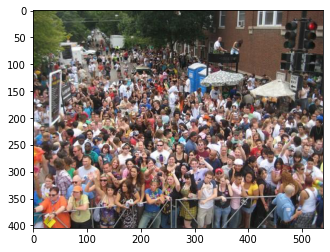

In [ ]:
plt.imshow(Image.open(img_paths[1]))

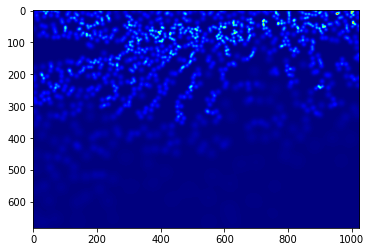

In [ ]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

Trying to find how many people are present in this image using the groundtruth values by summing it all up.

In [ ]:
np.sum(groundtruth)

904.1688

In [ ]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

The next step is to train our model. The code is implemented in train.py file. And we have run this train.py file by passing the arguments. We trained this model for 400 epochs. For 400 epochs, the model more than around 24 hours to complete. 

This train.py file is from the reference https://github.com/leeyeehoo/CSRNet-pytorch, also related to the research paper mentioned earlier.

Once the below code is implemented, then a pretrained weight file will be generated in the name of 0model_best.pth.tar

### **`Note: Please do not run the below cell as this will take atleast a day to train the model`**

### **CSRNET**
The CSRNet model comprises of two major components: a convolutional neural network (CNN) as the front-end for 2D feature extraction and a dilated CNN for the back-end, which uses dilated kernels to deliver larger reception fields and to replace pooling operations. The main concept of using dilated convolutions is to enlarge the kernel without increasing the parameters.

<p> Suppose we have an input x(m,n), a filter w(i,j) and the dilation rate r. The output y(m,n) will be:


>$y(m,n)=\sum_{i=1}^M \sum_{i=1}^N x(m+r*i,n+r*j)w(i,j)$

We can generalize this equation using a (k*k) kernel with a dilation rate r. The kernel enlarges to:

>$([k + (k-1)*(r-1)] * [k + (k-1)*(r-1)])$

Stochastic Gradient Descent is used to train the CSRNet as an end-to-end structure. During training the fixed learning rate is 1e-6.

<p> The evaluation metric used is Mean Absolute Error given by:

>$MAE = \frac{1}{N} \sum_{i=1}^N |C_{i}-C_{i}^{GT}$

Here Ci is the estimated count:
>$C_{i} = \sum_{l=1}^L \sum_{w=1}^W z_{l,w}$
L and W are the width of the predicted density map.

<p> This model will first predict the density map for a given image. The pixel value will be 0 if no person is present. A certain pre-defined value will be assigned if that pixel corresponds to a person. So, calculating the total pixel values corresponding to a person will give us the count of people in that image.

In [ ]:
!python3 "/content/drive/My Drive/dataset/train.py" "/content/drive/My Drive/dataset/part_a_train.json" "/content/drive/My Drive/dataset/part_a_val.json" 0 0 

## **Validating the results**

In [ ]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [ ]:
#defining the location of dataset
root = '/content/drive/My Drive/dataset/'
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [ ]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [ ]:
import h5py
import torch
import shutil

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')            

In [ ]:
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [ ]:
model = CSRNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
#defining the model
model = model.cuda()

The pretrained weight file is /content/drive/My Drive/dataset/0model_best.pth.tar location. So fetching the weight values from it.

In [ ]:
#loading the trained weights
checkpoint = torch.load('/content/drive/My Drive/dataset/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [02:16<00:00,  1.33it/s]

75.69090073973268


**We got an MAE value of 75.69 which pretty good we feel.**

In [ ]:
print (mae/len(img_paths))

75.69090073973268


### **RESULTS - With Shanghai Dataset**

The below results are tested from the taking the test file from the drive.

Drive Location is /content/drive/My Drive/dataset/part_A_final/test_data/images/

We have displayed the Original Count, Predicted Count and the Actual Count.

**Image 1: (IMG_100)**

Predicted Count : 384<br>
Actual Count : 384<br>

**Image 2: (IMG_77)**

Predicted Count : 216<br>
Actual Count : 205<br>

**Image 3: (IMG_47)**

Predicted Count : 149<br>
Actual Count : 119<br>

**Image 4: (IMG_32)**

Predicted Count : 984<br>
Actual Count : 956<br>

Predicted Count :  384


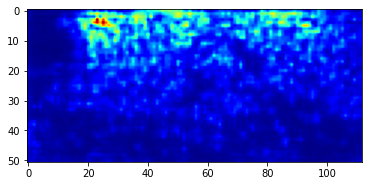

Original Count :  384


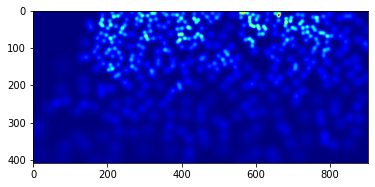

Original Image


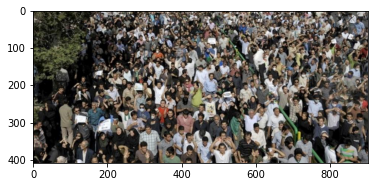

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_100.jpg'))
plt.show()

Predicted Count :  216


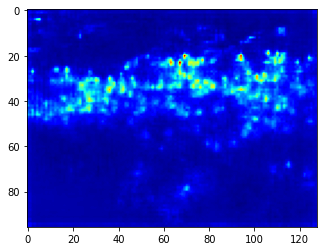

Original Count :  205


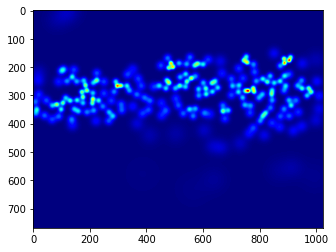

Original Image


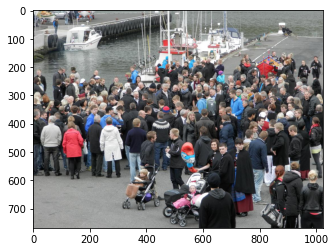

In [ ]:
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_77.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg'))
plt.show()

Predicted Count :  149


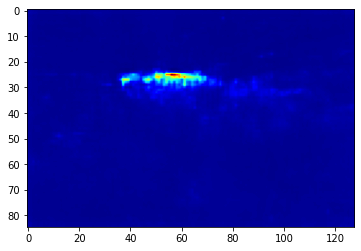

Original Count :  118


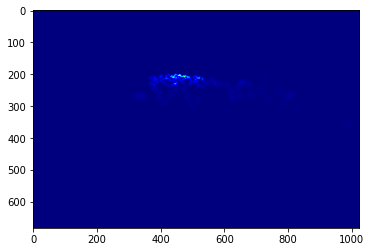

Original Image


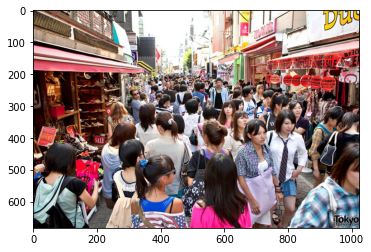

In [ ]:
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_43.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_43.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_43.jpg'))
plt.show()

Predicted Count :  984


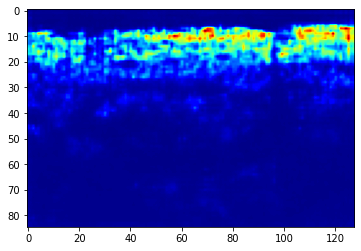

Original Count :  956


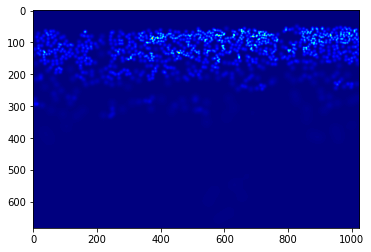

Original Image


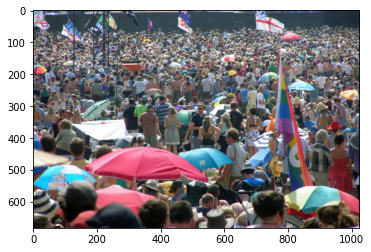

In [ ]:
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_32.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_32.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_32.jpg'))
plt.show()

### **RESULTS - With Jhu Dataset**

The below results are tested from the taking the test file from the drive.

Drive Location is /content/drive/My Drive/dataset/Jhu Dataset/

We have displayed the Original Count, Predicted Count and the Actual Count.

**Image 1: (IMG_0004)**

Predicted Count : 63<br>
Actual Count : 59<br>

**Image 2: (IMG_0006)**

Predicted Count : 306<br>
Actual Count : 299<br>

**Image 3: (IMG_0132)**

Predicted Count : 508<br>
Actual Count : 542<br>

**Image 4: (IMG_0211)**

Predicted Count : 1143<br>
Actual Count : 1085<br>

Predicted Count :  63


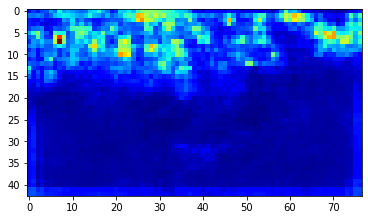

Actual Count : 59
Original Image


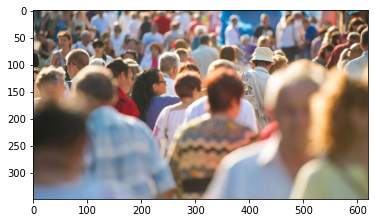

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/dataset/Jhu Dataset/0004.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

print("Actual Count : 59")
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/dataset/Jhu Dataset/0004.jpg'))
plt.show()

Predicted Count :  306


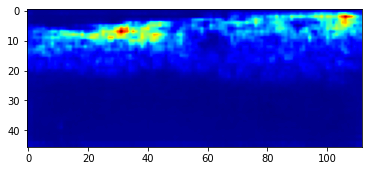

Actual Count : 299
Original Image


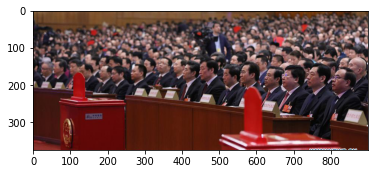

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/dataset/Jhu Dataset/0006.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

print("Actual Count : 299")
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/dataset/Jhu Dataset/0006.jpg'))
plt.show()

Predicted Count :  508


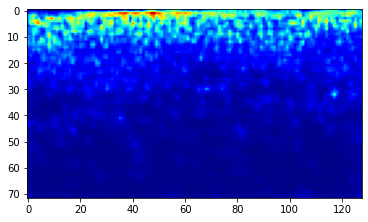

Actual Count : 542
Original Image


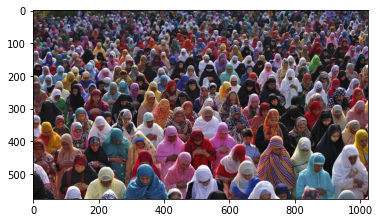

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/dataset/Jhu Dataset/0211.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

print("Actual Count : 542")
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/dataset/Jhu Dataset/0211.jpg'))
plt.show()

Predicted Count :  1143


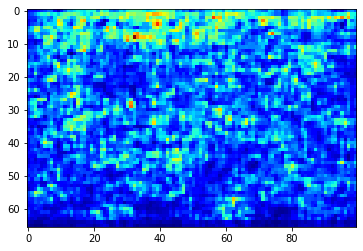

Actual Count : 1085
Original Image


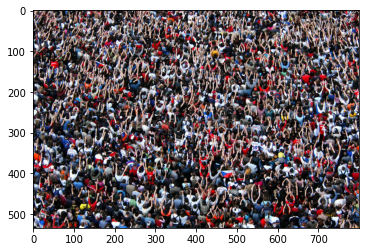

In [ ]:
img = transform(Image.open('/content/drive/MyDrive/dataset/Jhu Dataset/0132.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

print("Actual Count : 1085")
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/dataset/Jhu Dataset/0132.jpg'))
plt.show()